# Capstone Project - The Battle of the Neighborhoods (Week 2)

## Applied Data Science Capstone by IBM / Coursera

_by Ludovic D'ALESSIO_

---
# Opening a traditional French bakery in Paris, France

<table><tr><td>
<img src='https://image.freepik.com/free-vector/paris-cityscape-illustration-cartoon-paris-landmarks-night-eiffel-tower_33099-291.jpg' width='470'/>
</td><td>
<img src='https://i0.wp.com/worldwideadventurers.com/wp-content/uploads/2012/04/baguette-tradition-paris.jpg?w=600' width='396'/>
</td></tr></table>

### Table of contents

* [Introduction - Business Problem](#Introduction:-Business-Problem)
* [Data](#Data)
* [Methodology](#Methodology)
* [Analysis](#Analysis)
* [Results](#Results)
* [Discussion](#Discussion)
* [Conclusion](#conclusion)


## Introduction: Business Problem ##

<p>In this project we will try to find suitable locations to open a <b>bakery</b> in <b>Paris</b>.</p>
<p>Let's imagine ourselves in the shoes of a young, gifted, traditional French baker willing to settle down in Paris. France is well known for its culinary wealth, and bakery makes no exception. An infinite variety of breads, croissants, pastries... hold a significant part of the <i><b>French Way of Life</b></i>. French people are very proud of their bakeries, and you can find them everywhere. Every district, every block has its own bakery, which really plays an important part in the neighborhood's life.</p>

<p>So the question is: <b>how to find a suitable place to open a new bakery in a city already crowded with bakeries of all kinds?</b></p>
<p>Paris is a truly beautiful place, a mix of well-known landmarks, historical architecture, residential buildings and small local shops. Paris itself is quite small and homogeneous. Unlike the large U.S. cities for example, the business center is outside the city, and there are residential areas just everywhere.</p>
<p>Many factors could be taken into consideration to determine if an area is suitable to open a new traditional and high standing bakery, but we will only concentrate in this project on the three criteria below:<ul>
    <li><i><u>Density of population</u></i> in the area: you typically don't want to take you car to buy your bread for the day or the chocolate croissant for your breakfast, so the area's attractiveness is direcly linked to the number of Parisians living around.
    <li><i><u>Number of bakeries already present in the area</u></i>: competition is good for the customers, but as a shop owner less competitors means more market share.
    <li><i><u>Distance of to the closest "quality bakery"</u></i>: all the bakeries are different and you might want to walk a bit more to find an exceptional quality, hand-made product, within a reasonable range; so an area where the closest top bakery is more than one kilometer away offers a true opportunity for a baker able and willing to provide this level of service. </li>
</ul></p>

## Data ##

### Data sources overview

The following data sources will be used to generate the required information:
* **Paris population density** can be found on [Wikipedia](https://fr.wikipedia.org/wiki/Liste_des_quartiers_administratifs_de_Paris) per borough and per administrative district
* **Paris boroughs and districts shapes**, in geojson format, can be downloaded for free on  [opendata.paris.fr](https://opendata.paris.fr/explore/dataset/quartier_paris/export/?location=13,48.85879,2.34704&basemap=jawg.streets) website
* **The list and geolocalization** of all the bakeries in Paris will be retrieved through [Foursquare API](https://developer.foursquare.com/developer/) standard requests
* **Bakeries ratings**, that will be used to identify top bakeries, will be retrieved through **Foursquare API** premium requests
* The [folium](https://github.com/python-visualization/folium) and [geopy.geocoders](https://github.com/geopy/geopy) packages will be used respectively to visualize data on a map and to retrieve map coordinates from given addresses.

All those pieces of data are completely and freely available on the internet. The following sections describe the data sources in detail and the data once retrieved.

### Population density

Paris is conveniently divided into 20 boroughs, called *arrondissements*, arranged in spiral and numbered from 1 to 20 starting from the center:
<img src='http://www.paris-en-photos.fr/wp-content/uploads/2008/08/paris-arrondissements-300x216.png'/>
However, those boroughs are sometimes quite big and the population density is not homogeneous. Fortunately, each of them is also divided into 4 administrative districts, which makes a total of **80 districts** covering the whole city. The list of the districts and their characteristics can be found [here on Wikipedia](https://fr.wikipedia.org/wiki/Liste_des_quartiers_administratifs_de_Paris) (it's in French as the similar page in English does not directly show the density figures).<br>
We will also need the *geojson* coordinates of the districts, that can be found on the [opendata.paris.fr](https://opendata.paris.fr/explore/dataset/quartier_paris/export/?location=13,48.85879,2.34704&basemap=jawg.streets) website.

We can download the Wikipedia table directly into a Pandas dataframe.

In [1]:
import pandas as pd
df_districts = pd.read_html('https://fr.wikipedia.org/wiki/Liste_des_quartiers_administratifs_de_Paris')[0]
df_districts.head(2)

Arrondissement[1],[n 1] Quartiers                Quartiers.1  \
0  1er arrondissementdit « du Louvre »       1er  Saint-Germain-l'Auxerrois   
1  1er arrondissementdit « du Louvre »        2e                     Halles   

  Population en1999 (hab.)[2]  Superficie(ha)[2] Densitéhab/km2  Plan  
0                       1 672                869          1 924   NaN  
1                       8 984                412         21 806   NaN

In [2]:
df_districts.dtypes

Arrondissement[1],[n 1]         object
Quartiers                       object
Quartiers.1                     object
Population en1999 (hab.)[2]     object
Superficie(ha)[2]                int64
Densitéhab/km2                  object
Plan                           float64
dtype: object

In [3]:
df_districts.shape

(80, 7)

It looks great as we retrieved the expected 80 lines, however we need to drop the first and last columns, and change the names and types of the other columns:

In [4]:
df_districts = df_districts.drop([df_districts.columns[0], df_districts.columns[-1]], axis=1)
df_districts.columns = ['Borough Nb', 'District Name', 'Population', 'Area', 'Density']
df_districts['Population'] = pd.to_numeric(df_districts['Population'].str.replace('[^0-9]', ''))
df_districts['Density'] = pd.to_numeric(df_districts['Density'].str.replace('[^0-9]', ''))
df_districts['Borough Nb'] = pd.to_numeric(df_districts['Borough Nb'].str.replace('[^0-9]', ''))
df_districts.head(2)

Borough Nb              District Name  Population  Area  Density
0           1  Saint-Germain-l'Auxerrois        1672   869     1924
1           2                     Halles        8984   412    21806

### Districts shapes

Now let's display the boroughs as a choropleth map according to their population density. We have downloaded beforehand the *geojson* files from [opendata.paris.fr](https://opendata.paris.fr/explore/dataset/quartier_paris/export/?location=13,48.85879,2.34704&basemap=jawg.streets) for the districts and the boroughs.

In [5]:
# imports
import json
import folium
from geopy.geocoders import Nominatim

# create a map around Paris 
geolocator = Nominatim(user_agent="capstone_explorer")
loc = geolocator.geocode("Paris, France")
paris_coord = [loc.latitude, loc.longitude]
map_paris = folium.Map(location=paris_coord, zoom_start=12)

# draw boroughs and districts
geo_boroughs = json.load(open("boroughs_paris.geojson"))
geo_districts = json.load(open("districts_paris.geojson"))
folium.Choropleth(geo_data=geo_districts, key_on='feature.properties.c_qu', data=df_districts,
    columns=['Borough Nb', 'Density'], fill_color='Oranges', fill_opacity=0.5, name="choro").add_to(map_paris)
folium.GeoJson(geo_boroughs, style_function=lambda x:{'color':'darkblue','weight':3,'fill':False}).add_to(map_paris)

# show mamp
map_paris

### List and geolocalization of the bakeries

To retrieve the list of bakeries around a given point we use the Foursquare API with a verified account, that allows for 99,500 standard and 500 premium requests per day. Below the account configuration:

In [6]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

CLIENT_ID = 'X44GZE3TFHMZN4XSSRDPNQELI4O3WQXC2XBBI5VOWY52J3AE' # Foursquare ID
CLIENT_SECRET = 'BQSEQ22WUR5Z1P25YZN0GPBWK0T0PTKJ3C5HBW0YLWXP2A1C' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
BAKERY_CATEGORY = '4bf58dd8d48988d16a941735' # Foursquare Category Id for bakeries
LIMIT = 1000 # Limit we will use as the maximum number of responses we want to get from Foursquare requests 

To demonstrate how Foursquare API works, let's retrieve the bakeries within 600 meters of the center of one random district; for the sake of simplicity, we'll use the first district listed in the geojson file retrieved from [opendata.paris.fr](https://opendata.paris.fr/explore/dataset/quartier_paris/export/?location=13,48.85879,2.34704&basemap=jawg.streets).

In [7]:
# coordinates of the district center
center_coord = geo_districts['features'][0]['properties']['geom_x_y']
# area we consider around the center, in meters
radius = 600

# build the URL corresponding to the Foursquare request
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID, CLIENT_SECRET, VERSION, center_coord[0], center_coord[1], radius, LIMIT, BAKERY_CATEGORY)

# determine if a venue is a bakery
def is_bakery(venue):
    for cat in venue['categories']:
        if cat['id'] == BAKERY_CATEGORY:
            return True
    # 'Bakery' category not found in the list of categories
    return False

# send request
results = requests.get(url).json()['response']['groups'][0]['items']

# store results in list
bakeries = [(item['venue']['id'],
             item['venue']['name'],
             (item['venue']['location']['lat'], item['venue']['location']['lng']),
             item['venue']['location']['formattedAddress'])
    for item in results if is_bakery(item['venue'])]

# transform to dataframe
df_bakeries = pd.DataFrame(bakeries, columns=['Id', 'Name', 'Coord', 'Address'])
df_bakeries.shape

(15, 4)

Ok so we found 15 bakeries around the district's center.

### Bakeries' ratings

To retrieve the bakeries' rating we use another type of request from the Foursquare API that provides detailed information on a specific venue. To illustrate how it works, we will try to retrieve the ratings of all the 15 bakeries found in the previous section. It is important to note that not all venues in Foursquare are rated, so if the request returns no results we will assign NaN as the bakery's rating.

In [8]:
import numpy as np
import math

# Fetch the rating from Foursquare using the bakery Id
def get_rating(row):
    try:
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            row['Id'], CLIENT_ID, CLIENT_SECRET, VERSION)
        return requests.get(url).json()['response']['venue']['rating']
    except:
        return np.NaN
    
# Retrieve the rating for all the bakeries and add it as a new column in the dataframe
df_bakeries['Rating'] = df_bakeries.apply(lambda row: get_rating(row), axis=1)
df_bakeries[['Name', 'Address', 'Rating']].head(8)

Name  \
0                          Boulangerie Saint-Antoine   
1                                         Miss Manon   
2                                  Maison Landemaine   
3                                               Paul   
4                                      Maison Passos   
5                                Aux Désirs de Manon   
6                         Boulangerie Maison Hilaire   
7  Chambre Professionnelle des Artisans Boulanger...   

                                             Address  Rating  
0        [29 rue Saint-Antoine, 75004 Paris, France]     8.3  
1        [87 rue Saint-Antoine, 75004 Paris, France]     7.9  
2  [28 boulevard Beaumarchais (Rue du Pasteur Wag...     7.7  
3               [Rue de Rivoli, 75001 Paris, France]     7.1  
4       [28 rue de la Roquette, 75011 Paris, France]     6.8  
5       [129 rue Saint-Antoine, 75004 Paris, France]     6.3  
6        [11 rue Saint-Antoine, 75004 Paris, France]     NaN  
7              [7 Quai d'Anjou, 75004 Paris, France]     NaN

Finally, let's plot the bakeries we have discovered on a map centered around the district. We will plot the bakeries using different colors: in green the bakeries with a high rating (>= 8.0), in orange the other rated bakeries, and in black those that don't have any rating.

In [9]:
# Create the map
map_district = folium.Map(location=center_coord, zoom_start=15)

# Draw districts borders
folium.GeoJson(geo_districts, style_function=lambda x:{'color':'darkblue','weight':3,'fill':False}).add_to(map_district)

# Identify in red the center of the district and the area within 600m of the center
folium.Marker(center_coord).add_to(map_district)
folium.Circle(center_coord, radius=600, color="red", fill=True, fill_opacity=.1).add_to(map_district)

# Place the bakeries with the right color
for coord, name, rating in zip(df_bakeries['Coord'], df_bakeries['Name'], df_bakeries['Rating']):
    if math.isnan(rating):
        folium.CircleMarker(coord, radius=5, color='black', fill=True, fill_opacity=.7,
            popup='{} (no rating)'.format(name)).add_to(map_district)
    else:
        folium.CircleMarker(coord, radius=5, color=('green' if rating>=8 else 'blue'), fill=True, fill_opacity=.7,
            popup='{} ({})'.format(name, rating)).add_to(map_district)
        
# Show map
map_district

<p>On this small example, we observe that a very small proportion of bakeries are highly rated (only 1 in 15 in our example is rated above 8.0), while the majority of the bakeries are not rated. These proportions need to be confirmed on a larger scale but this is not surprising: people don't usually put comments on each and every place they go, but only on places they found truly exceptional, or at least unusual, or for which they had a high expectation, which represent only a minority of them.</p>
<p>Going forward we will split the bakeries in two categories:<ul>
    <li>The "<b>top</b>" bakeries, with a rating equal to or above 8.0
    <li>The "<b>ordinary</b>" bakeries, either with no rating or with a rating strictly below 8.0</ul></p>

<a id='#methodology'></a>

## Methodology ##

Now that we have familiarized ourselved with the data, we can design a methodology to determine good candidate areas to open our high-standing bakery.<ol>
<li>The first step will be to <b><i>retrieve the full list of bakeries</i></b> with their geolocalization and their rating. 
<li>The second step will be to <b><i>divide Paris</i></b> into small, <b><i>hexagonal-shaped</i></b>, areas of equal size. For each of those areas we will estimate the 3 metrics that will be taken into account in our decision: the <u>popultion density</u>, the <u>average distance of any point in the area to the closest "top" bakery</u>, and the <u>number of bakeries per 1000 inhabitants</u>.
<li>The final step will consist in grouping the areas into <b><i>different clusters according to their similarities</i></b> on the 3 characteristics determined in the second step. We will then determine the cluster of areas that present the <b><i>best mix of characteristics</i></b>.</ol>
To confirm the results, we will <b><i>assign a score</i></b> to each area according to how it performs on the three different measures, and eventually conclude on which areas seem to us the most suitable to welcome a new top bakery.

During this process we will need a few technical functions, that are defined and explained below:

In [10]:
from shapely.geometry import shape, Point
EARTH_RADIUS = 6371000 # from Google

# Determine the distance in meters between 2 points p1 and p2, both modeled as [latitude, longitude]
def dist_in_m(p1, p2):
    avg_lat = (p1[0] + p2[0]) / 2
    dlat = p2[0] - p1[0]
    dlon = p2[1] - p1[1]
    dx = EARTH_RADIUS * dlon * math.pi / 180 * math.cos(avg_lat * math.pi / 180)
    dy = EARTH_RADIUS * dlat * math.pi / 180
    return math.sqrt(dx*dx + dy*dy)

# Determine in which district, if any, lays the given point p modeled as [latitude, longitude]
def in_which_district(p):
    point = Point(p[1], p[0])
    for district in geo_districts['features']:
        poly = shape(district['geometry'])
        if poly.contains(point):
            return district['properties']['c_qu']
    # at this point no district was found
    return 0

# Translate a given point p modeled as [latitude, longitude] by dx meters in longitude and dy meters in latitude
def move_in_m(p, dx, dy):
    dlat = dy * 180 / (EARTH_RADIUS * math.pi)
    dlon = dx * 180 / (EARTH_RADIUS * math.pi * math.cos(p[0] * math.pi / 180))
    return [p[0] + dlat, p[1] + dlon]

<a id='#analysis'></a>

## Analysis ##

### Complete list of bakeries

To limit the number of bakeries retrieved each time we request Foursquare, we will fetch them district by district. Each time, we will define the search area as the smallest circle that completely covers the shape of the district (by defining the radius as the largest distance between the center of the district and any of the vertexes of the polygon defining the shape of the district), and make sure that each bakery retrieved is really inside the district (in order not to double count bakeries that are inside a district and close enough to another district). 

In [11]:
all_bakeries = []

# Iterate on districts 
for district in geo_districts['features']:
    # find radius = max distance between district center and polygon vertexes
    center = district['properties']['geom_x_y']
    max_dist = 0
    for poly in district['geometry']['coordinates']:
        for p in poly:
            # careful here point if defined as [lon, lat] so we need to reverse it
            dist_from_center = dist_in_m([p[1], p[0]], center)
            if dist_from_center > max_dist:
                max_dist = dist_from_center
    
    # retrieve bakeries
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID, CLIENT_SECRET, VERSION, center[0], center[1], max_dist, LIMIT, BAKERY_CATEGORY)
    results = requests.get(url).json()['response']['groups'][0]['items']
    bakeries = [(district['properties']['c_qu'],
                 item['venue']['id'],
                 item['venue']['name'],
                 (item['venue']['location']['lat'], item['venue']['location']['lng']))
            for item in results if is_bakery(item['venue'])]

    # check if each bakery is within disctrict bounds
    polygon = shape(district['geometry'])
    for bakery in bakeries:
        point = Point(bakery[3][1], bakery[3][0])
        if polygon.contains(point):
            all_bakeries.append(bakery)
            
# transform to dataframe
df_bakeries = pd.DataFrame(all_bakeries, columns=['District Id', 'Id', 'Name', 'Coord'])
df_bakeries.shape

(804, 4)

So there are 804 bakeries in Paris, according to Foursquare. Now we need to retrieve their rating. The problem is that with a standard (free) Foursquare account, we can only make 500 premium requests per day. As a consequence, we retrieved beforehand the ratings (in several days) and stored them in a *.csv* file.

In [12]:
df_ratings = pd.read_csv('ratings.csv')
df_ratings.head(2)

Id  Rating
0  4e21e53d88774a43b76edb2d     7.5
1  5c937dab475abd002c6a8c49     7.3

In [13]:
df_ratings.shape

(349, 2)

Let's merge the bakeries and the ratings dataframe: 

In [14]:
df_bakeries_all = pd.merge(df_bakeries, df_ratings, how="outer", on='Id')
df_bakeries_all.head()

District Id                        Id  \
0           15  4b80f65ef964a520799330e3   
1           15  50b38471e4b07a713e455119   
2           15  4c3ee9bb51dee21e2d35eb6e   
3           18  4bdd659db0f5c928d2464ce3   
4           18  4bf5716694af2d7fa2ba3b72   

                                        Name  \
0                  Boulangerie Saint-Antoine   
1                 Boulangerie Maison Hilaire   
2                               Maison Henry   
3  Le Fournil de Mouffetard - Maison Morange   
4                            Maison Grégoire   

                                      Coord  Rating  
0    (48.85363271223415, 2.365220189094543)     8.3  
1   (48.85340217779009, 2.3663440346717834)     NaN  
2   (48.847886021323966, 2.365128993988037)     NaN  
3  (48.840198438097524, 2.3498471081256866)     8.6  
4    (48.84370464932914, 2.352389640982933)     7.1

Let's also identify the **top** bakeries in a dedicated dataframe:

In [15]:
df_bakeries_top = df_bakeries_all[df_bakeries_all['Rating']>=8.0].reset_index()
df_bakeries_top.shape

(82, 6)

Let's visualize the bakeries on the map, identifying the top bakeries in green, and the others in blue:

In [16]:
# Create the map
map_paris = folium.Map(location=paris_coord, zoom_start=12)

# Draw districts borders
folium.GeoJson(geo_districts, style_function=lambda x:{'color':'darkblue','weight':2,'fill':False}).add_to(map_paris)

# Place the bakeries with the roight color
for coord, rating in zip(df_bakeries_all['Coord'], df_bakeries_all['Rating']):
    folium.CircleMarker(coord, radius=(2 if rating>=8 else 1), color=('red' if rating>=8 else 'blue'),
        fill=False).add_to(map_paris)
        
# Show map
map_paris

### Division of Paris into hexagons

In this step we want to create a patchwork of hexagonal shapes that completely covers Paris. We choose 200m as the hexagon side.

In [17]:
HEXAGON_SIZE = 200 # in meters

# Coordinates of the vertexes of a hexagon of unit 1
UNIT_HEXAGON_COORD = ((0, 1), (math.sqrt(3)/2, .5), (math.sqrt(3)/2, -.5), (0, -1), (-math.sqrt(3)/2, -.5), (-math.sqrt(3)/2, .5))

# Returns the coordinates of the vertexes of the hexagon centered on the given center, in [lat, lon]
def get_hexagon_coord(center_coord):
    return [move_in_m(center_coord, x*HEXAGON_SIZE, y*HEXAGON_SIZE) for (x,y) in UNIT_HEXAGON_COORD]

# global shape of the patchwork
MAX_LENGTH = 12500
MAX_HEIGHT = 10000
START = move_in_m(paris_coord, -7700, -5000)

# Iterate within the global shape
hexagons = []
y = 0
while y * HEXAGON_SIZE * 1.5 <= MAX_HEIGHT:
    x = y % 2
    while x * HEXAGON_SIZE * math.sqrt(3)/2 <= MAX_LENGTH:
        hexa_center = move_in_m(START, x * HEXAGON_SIZE * math.sqrt(3)/2, y * HEXAGON_SIZE * 1.5)
        district = in_which_district(hexa_center)
        if district>0:
            hexa_poly = get_hexagon_coord(hexa_center)
            hexagons.append([x, y, hexa_center, hexa_poly, district])
        x += 2
    y += 1
        
map_paris = folium.Map(location=paris_coord, zoom_start=12)
for hexagon in hexagons:
    folium.Polygon(hexagon[3], color='blue', weight=1, fill=False).add_to(map_paris)
map_paris

In [18]:
df_hexagons = pd.DataFrame(hexagons, columns=['x', 'y', 'centroid', 'polygon', 'district'])
df_hexagons.shape

(898, 5)

Now that we have covered Paris with small hexagonal shapes, we need to attribute to each area the 5 following features:
* The **average population density**: considering the 7 points consisting of the 6 vertexes and the center, we determine the districts where the points are (on peripheral hexagons, some vertexes might be outside any district) and we compute the average of the corresponsing densities
* The **number of bakeries inside** the area: we simply count the number of bakeries located within the hexagon
* The **number of bakeries around** the area: we count the number of bakeries inside all of the 6 (or less for a peripheral hexagon) areas surrounding the considered hexagon
* The **average distance to a top bakery**: considering the 7 points consisting of the 6 vertexes and the center, we compute the average of the distance between each point and the closest top bakery
* The **number of bakeries per 1000 inhabitants**: it it calculated as 1000 x nb_bakeries_around / population, where the population is the density multiplied by the surface of a hexagon in km^2

The code is shown below. The results are added to the *df_hexagons* dataframe.

In [19]:
# we will need to address the districts by their number
df_districts.reset_index(inplace=True)
df_districts.set_index('Borough Nb', inplace=True)

# Compute the average density of the area by averaging the densities of the districts in which the vertexes and the center are
def compute_average_density(row):
    points = row['polygon'] + [row['centroid']]
    densities = []
    for p in points:
        district = in_which_district(p)
        if district>0:
            densities.append(df_districts.loc[district, 'Density'])
    return sum(densities)/len(densities)

# Count the number of bakeries inside the area
def count_bakeries_inside(row):
    poly = shape({'type':'Polygon', 'coordinates': [row['polygon']]})
    count = 0
    for bakery in df_bakeries_all['Coord']:
        if poly.contains(Point(bakery[0], bakery[1])):
            count += 1
    return count

# Count the number of bakeries around the area, including those within this area
def count_bakeries_around(row, df):
    x, y = row['x'], row['y']
    return sum(df.loc[(df.x>=x-2) & (df.x<=x+2) & (df.y>=y-1) & (df.y<=y+1)]['bakeries_inside'])

# Compute the distance between the specified point [lat, lon] and the closest top bakery
def compute_distance_top_bakery(p):
    min_dist = 10000
    return min(df_bakeries_top['Coord'].apply(lambda x: dist_in_m(p,x)))

# Compute the average distance to the closest top bakery
def average_distance_top_bakery(row):
    points = row['polygon'] + [row['centroid']]
    distances = []
    for p in points:
        distances.append(compute_distance_top_bakery(p))
    return sum(distances)/len(distances)

# Compute all metrics and store them in df_hexagons
df_hexagons['bakeries_inside'] = df_hexagons.apply(lambda row: count_bakeries_inside(row), axis=1)
df = df_hexagons[['x', 'y', 'bakeries_inside']]
df_hexagons['bakeries_around'] = df_hexagons.apply(lambda row: count_bakeries_around(row, df), axis=1)
df_hexagons['density'] = df_hexagons.apply(lambda row: compute_average_density(row), axis=1)
df_hexagons['distance_top_bakery'] = df_hexagons.apply(lambda row: average_distance_top_bakery(row), axis=1)
HEXA_SURFACE = math.sqrt(3)/2*3*.2*.2
df_hexagons['bakeries_per_pop'] = df_hexagons['bakeries_around'] * 1000 / (df_hexagons['density'] * HEXA_SURFACE) 
df_hexagons.head()

x  y                                 centroid  \
0  38  2   [48.81712674933958, 2.336096505928946]   
1  40  2   [48.81712674933958, 2.340827218123624]   
2  42  2  [48.81712674933958, 2.3455579303183023]   
3  46  2   [48.81712674933958, 2.355019354707659]   
4  48  2  [48.81712674933958, 2.3597500669023375]   

                                             polygon  district  \
0  [[48.818925392551414, 2.336096505928946], [48....        54   
1  [[48.818925392551414, 2.340827218123624], [48....        54   
2  [[48.818925392551414, 2.3455579303183023], [48...        51   
3  [[48.818925392551414, 2.355019354707659], [48....        51   
4  [[48.818925392551414, 2.3597500669023375], [48...        51   

   bakeries_inside  bakeries_around  density  distance_top_bakery  \
0                0                0  14586.0           683.150678   
1                0                1  14586.0           478.164908   
2                0                2  23253.0           479.722136   
3                0                0  29031.0           975.908091   
4                0                0  29031.0          1293.688062   

   bakeries_per_pop  
0          0.000000  
1          0.659708  
2          0.827636  
3          0.000000  
4          0.000000

We are done with the calculations, let's now visualize the results. To be able to visualize the 3 features on the same map, we draw them in separate feature groups and add a layer control to the map.

In [20]:
# Return a color shade as a percent of the given base color
def get_color(percent, base_color):
    return "#{:02x}{:02x}{:02x}".format(
        255-int((255-base_color[0])*percent),
        255-int((255-base_color[1])*percent),
        255-int((255-base_color[2])*percent))

# Return a new feature group in which the given feature in drawn with the given color
def draw_feature(name, feature, color):
    fg = folium.FeatureGroup(name=name)
    max_f = max(df_hexagons[feature])
    for poly, f in zip(df_hexagons['polygon'], df_hexagons[feature]):
        folium.Polygon(poly, weight=0, fill=True, fill_opacity=.5, fill_color=get_color(f/max_f, color)).add_to(fg)
    return fg

# Create the Paris map and add the hexagons borders in a feature group
map_paris = folium.Map(location=paris_coord, zoom_start=12)
fg_border = folium.FeatureGroup(name='Borders')
for poly in df_hexagons['polygon']:
    folium.Polygon(poly, color='red', weight=1, fill=False).add_to(fg_border)
    
# Create and add all the features to the map
fg_border.add_to(map_paris)
draw_feature('Density', 'density', [188,106,16]).add_to(map_paris)
draw_feature('Distance to a top Bakery', 'distance_top_bakery', [0,192,0]).add_to(map_paris)
draw_feature('Number of bakeries per 1000 inhabitants', 'bakeries_per_pop', [192,0,192]).add_to(map_paris)

# Create a layer control and display the map
folium.LayerControl().add_to(map_paris)
map_paris

### Clustering

Let's analyze the *df_hexagons* dataframe and the distribution of the features we are interested in:

In [21]:
df_hexagons[df_hexagons.columns[-3:]].describe()

density  distance_top_bakery  bakeries_per_pop
count    898.000000           898.000000        898.000000
mean   24261.788885           910.327130          2.948793
std     8521.976380           720.490596          3.781869
min     1924.000000           125.727683          0.000000
25%    18816.000000           363.176230          0.747819
50%    23983.285714           661.965405          1.961644
75%    29984.464286          1248.814720          3.868790
max    45457.000000          3474.529448         43.496302

<p>The three features are very different ranges so we need to standardize them before running the clustering algorithm.</p>
<p>We will use the K-means method to group the areas into 15 clusters.

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# prepare X data
X = df_hexagons[df_hexagons.columns[-3:]].values
X_std = StandardScaler().fit_transform(X)

# run the algorithm
NB_CLUSTERS = 10
k_means = KMeans(init='k-means++', n_clusters=NB_CLUSTERS)
k_means.fit(X_std)
clusters = k_means.labels_
df_hexagons['clusters'] = clusters

# show average values per cluster
df_hexagons.groupby('clusters').mean()

x          y   district  bakeries_inside  bakeries_around  \
clusters                                                                      
0         27.442105  15.652632  59.905263         0.357895         2.315789   
1         33.658537  20.926829  19.463415         1.902439        13.951220   
2         55.178571  19.678571  67.410714         0.339286         2.723214   
3         38.808989  17.393258  31.303371         2.235955        14.000000   
4         32.341270  14.134921  50.809524         0.452381         3.507937   
5         36.000000  21.000000  21.250000         2.500000        17.375000   
6         26.901639  21.262295  66.491803         0.147541         1.131148   
7         49.411765  22.847059  52.082353         1.588235        10.764706   
8         36.200000  15.373333  36.960000         0.386667         4.186667   
9         37.985437  16.169903  56.878641         1.004854         6.762136   

               density  distance_top_bakery  bakeries_per_pop  
clusters                                                       
0         21317.438471          1830.262240          1.029695  
1         11432.466899           308.167401         11.853174  
2         31454.471747          1277.111190          0.815633  
3         21797.162119           347.242952          6.132117  
4         20533.763190           844.895242          1.642722  
5          5829.910714           332.808815         28.040943  
6         17694.702966          2724.606822          0.763300  
7         38361.710924           390.393212          2.718413  
8         11451.390476           655.932549          3.432419  
9         29113.982108           482.156598          2.236587

One cluster immediately stands out: the **cluster #2**. It has the 2nd highest population density, ranks 2nd for the number of bakeries per 1000 inhabitants with 0.816 (or 1 bakery for 1,226 people), and 3rd for the distance to a top bakery (1,277m in average).<br>
Let's highlight this cluster in a map.

In [30]:
map_paris = folium.Map(location=paris_coord, zoom_start=12)
for poly, cluster in zip(df_hexagons['polygon'], df_hexagons['clusters']):
    if cluster == 2:
        folium.Polygon(poly, color='blue', weight=1, fill=True, fill_opacity=.2).add_to(map_paris)
map_paris

## Results

At this point, here is what we have achieved:
* we have covered Paris in a patchwork of small haxagonal shapes
* we have computed for each hexagonal shape a few metrics that we want to take into account in our decision: the average population density, the number of bakeries around the area and the number of bakeries per 1000 inhabitants.
* we have clustered the hexagonal shapes according to how similar they look along those 3 metrics, and have identified one particular cluster that shows interesting scores in average on all 3 metrics.

In this section, we want to confirm quantitatively what we found in our analysis. Also, as cluster #6 is still quite populous, we want to go further in identifying a handful of hexagons in this cluster that are the most suitable to open our top-tiered bakery.

To this end, let's assign a score between 0 and 1 to each hexagon according to each feature but first, let's analyse the distribution of the 3 metrics among all the hexagons:

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

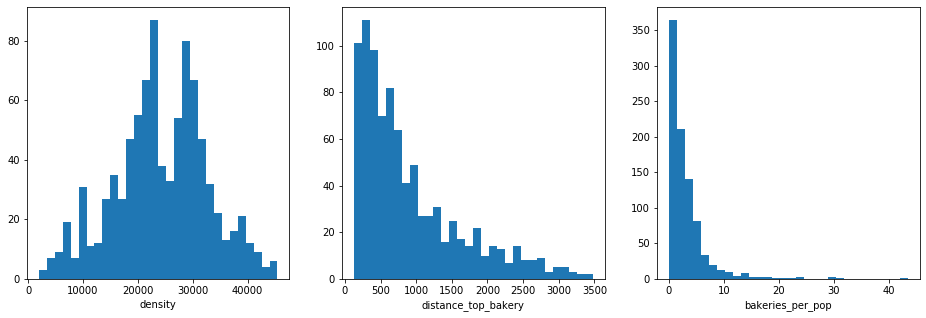

In [25]:
figure, axes = plt.subplots(1, 3, figsize=(16,5))
for i,feature in enumerate(df_hexagons.columns[-4:-1]):
    axes[i].hist(df_hexagons[feature], bins=30)
    axes[i].set_xlabel(feature)
plt.show()

We will assign the following scoring functions:
* The score for the **density** should be fully linear: the more the population, the more attractive the area, so we assign each area a score **directly proportional to the value of the density**, with the most dense hexagon receiving 1.
* For the **distance to a top bakery**, it should make no difference if the closest top bakery is far or very far away: if it's **far enough** that we can't go there by foot (let's take 1000m as threshold), **the score should be 1** (if we have to take the car, driving 1 or 3 km makes no difference). Under this threshold, the score is linear, with 0 corresponding to a distance of 0.
* For the **number of bakeries per 1000 inhabitants**, the score should be **inversely proportional** to the number of bakeries; however, beyond a certain threshold, there are just too many bakeries and it makes no sense opening a new one in the area, so **the score should be 0**. Let's use 20 as threshold (which corresponds to 1 bakery every 50 persons).

Graphically, the scores look like this:

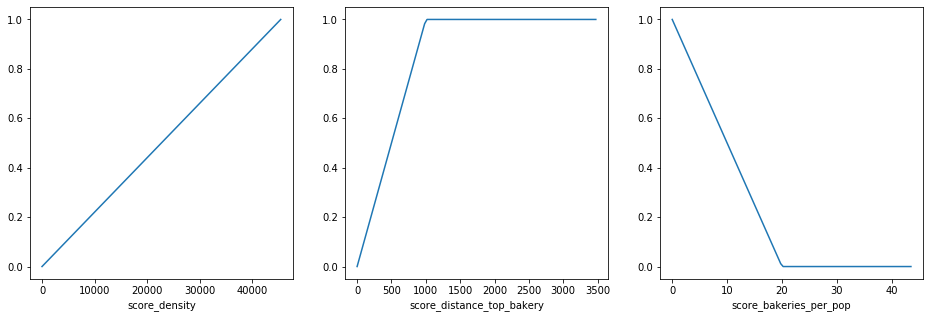

In [26]:
figure, axes = plt.subplots(1, 3, figsize=(16,5))
x = np.linspace(0, max(df_hexagons['density']), 100)
y = x/max(df_hexagons['density'])
axes[0].plot(x,y)
axes[0].set_xlabel('score_density')
x = np.linspace(0, max(df_hexagons['distance_top_bakery']), 100)
y = [min(1,a/1000) for a in x]
axes[1].plot(x,y)
axes[1].set_xlabel('score_distance_top_bakery')
x = np.linspace(0, max(df_hexagons['bakeries_per_pop']), 100)
y = [max(0,1-a/20) for a in x]
axes[2].plot(x,y)
axes[2].set_xlabel('score_bakeries_per_pop')
plt.show()

Let's implement the scoring functions and display the best performers:

In [31]:
# scores per feature
df_hexagons['score_density'] = df_hexagons['density'] / max(df_hexagons['density'])
df_hexagons['score_distance_top_bakery'] = [min(1, x / 1000) for x in df_hexagons['distance_top_bakery']]
df_hexagons['score_bakeries_per_pop'] = [max(0, 1 - x / 20) for x in df_hexagons['bakeries_per_pop']]

# total score as the sum of the 3 intermediate scores
df_hexagons['total_score'] = df_hexagons['score_density'] + df_hexagons['score_distance_top_bakery'] + df_hexagons['score_bakeries_per_pop']

# sort and show the top 10 performers
df_sorted = df_hexagons.sort_values(by=['total_score'], ascending=False)
df_sorted[df_sorted.columns[0:2].append(df_sorted.columns[7:])].head(10)

x   y       density  distance_top_bakery  bakeries_per_pop  clusters  \
798  54  28  41718.000000          1824.576153          0.922624         2   
888  43  33  39243.000000          1202.971214          0.245203         2   
774  53  27  41718.000000          1479.405036          1.383936         2   
820  53  29  41718.000000          2017.519234          1.383936         2   
799  56  28  41718.000000          2009.207142          1.383936         2   
821  55  29  41718.000000          2170.098599          1.614592         2   
660  59  23  40264.857143           950.043531          0.477960         7   
775  55  27  38400.571429          1668.152062          0.751747         2   
797  52  28  38305.714286          1679.872141          0.753609         2   
624  58  22  44328.000000           849.940465          0.651225         7   

     score_density  score_distance_top_bakery  score_bakeries_per_pop  \
798       0.917746                   1.000000                0.953869   
888       0.863299                   1.000000                0.987740   
774       0.917746                   1.000000                0.930803   
820       0.917746                   1.000000                0.930803   
799       0.917746                   1.000000                0.930803   
821       0.917746                   1.000000                0.919270   
660       0.885779                   0.950044                0.976102   
775       0.844767                   1.000000                0.962413   
797       0.842680                   1.000000                0.962320   
624       0.975163                   0.849940                0.967439   

     total_score  
798     2.871615  
888     2.851039  
774     2.848550  
820     2.848550  
799     2.848550  
821     2.837017  
660     2.811925  
775     2.807180  
797     2.805000  
624     2.792543

Unsurprisingly, **8 out of the 10 highest scores are from cluster #2**, including the top 6. This result allows us to confirm quantitatively what we infered from the clustering operation. Besides, we now have, among cluster #2 and overall, the best areas of Paris to open our bakery. Let's plot those areas on a map, in blue those from cluster #2, in red the others, and with the highest ranked being the more opaque, together with Paris boroughs and districts, to get an idea of where they are.

In [32]:
map_paris = folium.Map(location=paris_coord, zoom_start=12)
folium.GeoJson(geo_districts, style_function=lambda x:{'color':'black','weight':1,'fill':False}).add_to(map_paris)
folium.GeoJson(geo_boroughs, style_function=lambda x:{'color':'darkblue','weight':3,'fill':False}).add_to(map_paris)
opacity=.8
for poly, cluster in zip(df_sorted['polygon'].head(10), df_sorted['clusters'].head(10)):
    folium.Polygon(poly, color='blue' if cluster == 2 else 'red', weight=1, fill=True, fill_opacity=opacity).add_to(map_paris)
    opacity-=.08
map_paris

The result is striking: a cluster of 7 areas grouped together is clearly identifiable, with the area with the highest score in the center. This is definitively this area that we should choose to open our bakery. The 7 hexagons in the cluster all lie in one single administrative district; to conclude our study, let's find out which district it is, and the exact address of the center of the shape.

In [29]:
geolocator.reverse(df_sorted.reset_index().loc[0, 'centroid'])

Location(11, Passage de Flandre, Quartier de la Villette, Paris 19e Arrondissement, Paris, Île-de-France, France métropolitaine, 75019, France, (48.8870243, 2.3737772, 0.0))

This concludes our study: **Considering the 3 features *population density*, *number of bakeries around the area* and *average number of bakeries per 1000 inhabitants*, the ideal location where to open a high-standing, traditional French bakery is in the 19th borough, district of *La Vilette*, more precisely around the address: *11 Passage de Flandre***. 

## Discussion

<p>The goal of this project was to find an optimal place in Paris to open a new high-standing, traditional French bakery in Paris. We have defined 3 criteria that could be quantitatively assessed for any place in Paris using only resources freely available on the internet. We have come to a conclusion that identifies a single area particularly interesting within a popular neighborhood, with an average number of bakeries both in absolute and relatively to the population pretty low compared to the rest of Paris.</p>
<p>Of course, this result should be taken with a grain of salt. The metrics that have been used are just 3 among numerous possible criteria both quantitative and qualitative. In particular, the entrepreneur should be particularly mindful of the following:<ul>
    <li><b>The specificities of the neighborhood</b>: is the address easy to access by foot, or even better is it in or close to a pedestrian area? it is close to a marketplace, or at least to other local shops, especially other food businesses, that could attract customers? is it close to a subway station? is there a historical landmark nearby?
    <li><b>The type of population</b>: Parisians in average like their bakeries but what about a district with a high level of immigration? Are North-African and Chinese people, just to name a few, really keen to purchase a baguette every day from the bakery?
    <li><b>Economics</b>: how much does it cost to settle down in a specific area? how much is the local population willing to pay for a croissant?</ul>
<p>There are certainly many more questions to ask, but they go largely beyond the scope and the purpose of this project.</p>

## Conclusion

<p>In this project, we have used data science methodology and the Python language to answer a real-life question: what are the most suitable places in Paris to open a new, traditional French bakery.</p>
<p>We have demonstrated that, using only free resources and tools easily available on the internet, we could perform a thorough analysis based on a limited number of criteria and come up to a conclusion as to what area was the most attractive. While it is clear that a serious entrepreneur should run a much more detailed analysis, taking into account more criteria, and using larger sets of data, the methodology in this study could still be appropriate.</p>
<p>Moreover, the method that we have used here should not be restricted to traditional bakeries in Paris, instead it could benefit any competitive business willing to open a new store or shop in a big city: restaurants, barber shops, cinemas, nail salon etc.</p>